# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
import os;
from os.path import join as pathjoin;

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

import re;
import json;
import codecs;
from collections import defaultdict;

from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
from pandas.plotting import scatter_matrix;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

#preprocessing and transformation
from sklearn import preprocessing
from sklearn.preprocessing import normalize, MaxAbsScaler, RobustScaler;
from sklearn.decomposition import PCA;

from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn import linear_model;
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neural_network import MLPClassifier

 
#
from sklearn import feature_selection;
from sklearn import ensemble;

from sklearn.model_selection import train_test_split;
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

In [2]:
import seaborn as sns;
sns.set(color_codes=True);

In [3]:
import spacy
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""  #spacy causes a bug on pandas and this code fix it

In [4]:
import platform;
import sklearn;
import scipy;

print("|%-15s|%-40s|"%("PACK","VERSION"))
print("|%-15s|%-40s|"%('-'*15,'-'*40))
print('\n'.join(
    "|%-15s|%-40s|" % (pack, version)
    for pack, version in
    zip(['SO','NumPy','SciPy','Scikit-Learn','seaborn','spacy'],
        [platform.platform(), np.__version__, scipy.__version__, sklearn.__version__, sns.__version__, spacy.__version__])

))

|PACK           |VERSION                                 |
|---------------|----------------------------------------|
|SO             |Darwin-18.2.0-x86_64-i386-64bit         |
|NumPy          |1.15.4                                  |
|SciPy          |1.1.0                                   |
|Scikit-Learn   |0.20.1                                  |
|seaborn        |0.9.0                                   |
|spacy          |2.0.16                                  |


In [5]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format

In [6]:
#externalizing codes that is used in many notebooks and it is not experiment specific
import pan
#convert a sparse matrix into a dense for being used on PCA
from skleanExtensions import DenseTransformer;

#convert an array of text into an array of tokenized texts each token must contain text, tag_, pos_, dep_
from skleanExtensions import POSTagTransformer

### paths configuration

In [7]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [8]:
problems = pan.readCollectionsOfProblems(inputDir);

In [9]:
print(problems[0]['problem'])
print(problems[0].keys())

problem00001
dict_keys(['problem', 'language', 'encoding', 'candidates_folder_count', 'candidates', 'unknown'])


In [10]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [11]:
def cachingPOSTAG(problem, taggingVersion='TAG'):
    import json;
    print ("Tagging: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ');
    
    if not os.path.exists('POSTAG_cache'):
        os.makedirs('POSTAG_cache');
    
    _id = problem['problem']+problem['language'];
    filename = os.path.join('POSTAG_cache',taggingVersion+'_'+_id+'.json')
    if not os.path.exists(filename):
        lang = problem['language'];
        if lang == 'sp':
            lang = 'es';
        elif lang =='pl':
            print(lang, ' not supported');
            return ;

        train_docs, train_labels, _   = zip(*problem['candidates'])
        problem['training_docs_size'] = len(train_docs);
        test_docs, _, test_filename   = zip(*problem['unknown'])

        t0 = time()
        tagger = POSTagTransformer(language=lang);
        train_docs = tagger.fit_transform(train_docs);
        test_docs = tagger.fit_transform(test_docs);
        
        print("Annotation time %0.3fs" % (time() - t0))
        
        with open(filename,'w') as f:
            json.dump({
                'train':train_docs,
                'train_labels':train_labels,
                'test':test_docs,
                'test_filename':test_filename
            },f);
    else:
        with open(filename,'r') as f:
            data = json.load(f);

            train_docs = data['train'];
            train_labels = data['train_labels'];
            test_docs  = data['test'];
            test_filename = data['test_filename'];
    print('tagged')
    return train_docs, train_labels, test_docs, test_filename;

for problem in problems:
    cachingPOSTAG(problem)

Tagging: problem00001,  language: en,  tagged
Tagging: problem00002,  language: en,  tagged
Tagging: problem00003,  language: fr,  tagged
Tagging: problem00004,  language: fr,  tagged
Tagging: problem00005,  language: it,  tagged
Tagging: problem00006,  language: it,  tagged
Tagging: problem00007,  language: pl,  pl  not supported
Tagging: problem00008,  language: pl,  pl  not supported
Tagging: problem00009,  language: sp,  tagged
Tagging: problem00010,  language: sp,  tagged


In [12]:
train_docs, train_labels, test_docs, test_filename = cachingPOSTAG(problem)

Tagging: problem00010,  language: sp,  tagged


In [13]:
class FilterTagTransformer(BaseEstimator):
    def __init__(self,token='POS', parts=None):
        self.token = token;
        self.parts = parts;

    def transform(self, X, y=None):
        """ Return An array of tokens 
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_tokens]
            Array documents, where each document consists of a list of node
            and each node consist of a token and its correspondent tag
            
            [
            [('a','TAG1'),('b','TAG2')],
            [('a','TAG1')]
            ]
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if self.token == 'TAG':
            X = [' '.join([d[1].split('__')[0] for d in doc]) for doc in X]
        elif self.token == 'POS':
            if self.parts is None:
                X = [' '.join([d[2] for d in doc]) for doc in X];
            else:
                X = [' '.join([d[0] for d in doc if d[2] in self.parts]) for doc in X]
        elif self.token == 'DEP':
            X = [' '.join([d[3] for d in doc]) for doc in X]
        elif self.token == 'word_POS':
            if self.parts is None:
                X = [' '.join([d[0]+'/'+d[2] for d in doc]) for doc in X]
        elif self.token == 'filter':
            if self.parts is None:
                X = [' '.join([d[2] for d in doc]) for doc in X];
            else:
                X = [' '.join([d[0] for d in doc if d[2] in self.parts]) for doc in X]
        else:
            X = [' '.join([d[0] for d in doc]) for doc in X]
        
        return np.array(X);       

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

### analisando os demais parametros

In [14]:
def spaceTokenizer(x):
    return x.split(" ");

In [15]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ');
    
    lang = problem['language'];
    if lang == 'sp':
        lang = 'es';
    elif lang =='pl':
        print(lang, ' not supported');
        return None,None,None,None;
    
    
    train_docs, train_labels, test_docs, test_filename = cachingPOSTAG(problem)
    problem['training_docs_size'] = len(train_docs);

    t0 = time()
    
    pipeline = Pipeline([
        ('filter',FilterTagTransformer(token='TAG')),
        ('vect', CountVectorizer(
                                   tokenizer=spaceTokenizer,
                                   min_df=0.01,
                                   lowercase=False
                                  )),
        ('tfidf',  TfidfTransformer()),
        ('scaler', MaxAbsScaler()),
        ('dense',  DenseTransformer()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__ngram_range' :((1,1),(1,2),(1,3),(1,5)),
        'tfidf__use_idf'     :(True, False),
        'tfidf__sublinear_tf':(True, False),
        'tfidf__norm':('l1','l2'),
        'clf__C':(0.1,1,10),
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=4,
                               iid=False,
                               n_jobs=-1,
                               verbose=False,
                               scoring='f1_macro')
    
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("Gridsearh %0.3fs" % (time() - t0), end=' ')

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    
    #calculating the performance using PAN evaluation code
    f1,precision,recall,accuracy=pan.evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_,best_parameters, grid_search.best_estimator_;

In [16]:
result = [];
cv_result = [];
best_parameters = [];
estimators = [];
for problem in problems:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore");
        r, c, b, e = runML(problem);
        if r is None:
            continue;
        result.append(r);
        cv_result.append(c);
        estimators.append(e);
        b['problem'] = problem['problem'];
        best_parameters.append(b);


Problem: problem00001,  language: en,  Tagging: problem00001,  language: en,  tagged
Gridsearh 1107.958s Best score: 0.661
Best parameters set:
	clf__C: 10
	tfidf__norm: 'l2'
	tfidf__sublinear_tf: True
	tfidf__use_idf: True
	vect__ngram_range: (1, 2)

Problem: problem00002,  language: en,  Tagging: problem00002,  language: en,  tagged
Gridsearh 251.719s Best score: 0.840
Best parameters set:
	clf__C: 0.1
	tfidf__norm: 'l2'
	tfidf__sublinear_tf: False
	tfidf__use_idf: True
	vect__ngram_range: (1, 3)

Problem: problem00003,  language: fr,  Tagging: problem00003,  language: fr,  tagged
Gridsearh 1038.886s Best score: 0.530
Best parameters set:
	clf__C: 1
	tfidf__norm: 'l2'
	tfidf__sublinear_tf: True
	tfidf__use_idf: False
	vect__ngram_range: (1, 3)

Problem: problem00004,  language: fr,  Tagging: problem00004,  language: fr,  tagged
Gridsearh 256.516s Best score: 0.663
Best parameters set:
	clf__C: 0.1
	tfidf__norm: 'l2'
	tfidf__sublinear_tf: True
	tfidf__use_idf: True
	vect__ngram_range

In [17]:
df=pd.DataFrame(result)[['problem-name',
                     "language",
                     'AuthorCount',
                     'macro-f1','macro-precision','macro-recall' ,'micro-accuracy']]

In [18]:
df

,problem-name,language,AuthorCount,macro-f1,macro-precision,macro-recall,micro-accuracy
0,problem00001,en,20,0.3990,0.4550,0.4820,0.5050
1,problem00002,en,5,0.4750,0.4900,0.6500,0.5240
2,problem00003,fr,20,0.3860,0.3990,0.4350,0.3880
3,problem00004,fr,5,0.4130,0.4300,0.4470,0.4760
4,problem00005,it,20,0.4540,0.5020,0.5660,0.5380
5,problem00006,it,5,0.6360,0.6330,0.8000,0.6960
6,problem00009,sp,20,0.4710,0.4810,0.6030,0.4620
7,problem00010,sp,5,0.5040,0.5480,0.5350,0.5470


In [19]:
df[['macro-f1']].mean()

macro-f1   0.4673
dtype: float64

In [20]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [21]:
cv_result2 = [];
dfCV = pd.DataFrame();
for i, c in enumerate(cv_result):
    temp = pd.DataFrame(c);
    temp['language'] = result[i]['AuthorCount']
    temp['problem'] = int(re.sub('\D','',result[i]['problem-name']));
    temp['language'] = languages[result[i]['language']]
    dfCV = dfCV.append(temp);

for p in [
    'mean_test_score','std_test_score','mean_train_score',   
    'split0_test_score',
    'split1_test_score',
    'split2_test_score']:
    dfCV[p]=dfCV[p].astype(np.float32);

    
dfCV =dfCV[[
    'problem',
    'language',
    'rank_test_score',
    'param_vect__ngram_range',
    'param_tfidf__sublinear_tf',
    'param_tfidf__norm',
    'param_clf__C',
    'mean_test_score',   
    'std_test_score',

    'split0_test_score',
    'split1_test_score',
    'split2_test_score',

    'mean_score_time',
    'mean_fit_time',
    'std_fit_time',
    'std_score_time',
    'std_train_score',
]];

dfCV.rename(columns={
    'param_vect__ngram_range':'ngram_range',
    'param_tfidf__sublinear_tf':'sublinear_tf',
    'param_tfidf__smooth_idf':'smooth_idf',
    'param_tfidf__norm':'norm',
    'param_clf__C':'regularization',
},inplace=True);

#print('\',\n\''.join(dfCV.columns))


In [22]:
dfCV.head()

,problem,language,rank_test_score,ngram_range,sublinear_tf,norm,regularization,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,mean_score_time,mean_fit_time,std_fit_time,std_score_time,std_train_score
0,1,inglesa,94,"(1, 1)",True,l1,0.1000,0.2745,0.0452,0.2769,0.2643,0.2150,0.0247,0.0829,0.0123,0.0092,0.0538
1,1,inglesa,20,"(1, 2)",True,l1,0.1000,0.6176,0.0526,0.6217,0.5900,0.5586,0.0407,0.1523,0.0257,0.0098,0.0000
2,1,inglesa,12,"(1, 3)",True,l1,0.1000,0.6222,0.0486,0.5669,0.6167,0.6052,0.0780,0.3486,0.0171,0.0200,0.0000
3,1,inglesa,70,"(1, 5)",True,l1,0.1000,0.5291,0.0588,0.5467,0.4641,0.4888,0.2471,2.5010,0.5627,0.0829,0.0000
4,1,inglesa,93,"(1, 1)",True,l1,0.1000,0.2793,0.0521,0.3171,0.2460,0.2126,0.0218,0.0702,0.0060,0.0063,0.0550


## Saving the model

In [24]:
dfCV.to_csv('PANAA2018_POSTAG.csv', index=False)

In [25]:
dfCV = pd.read_csv('PANAA2018_POSTAG.csv', na_values='')

In [26]:
import pickle;
with open("PANAA2018_POSTAG.pkl","wb") as f:
    pickle.dump(estimators,f)

## understanding the model with reports

Podemos ver que para um mesmo problema mais de uma configuração é possível

In [27]:
print(' | '.join(best_parameters[0]['vect'].get_feature_names()[0:20]))

 |  '' |  -LRB- |  CC |  CD |  DT |  EX |  IN |  JJ |  MD |  NN |  NNP |  NNPS |  NNS |  PRP |  PRP$ |  RB |  UH |  VB |  VBD


In [28]:
(dfCV[dfCV.rank_test_score == 1]).drop_duplicates()[
    ['problem',
     'language',
    'mean_test_score',
    'std_test_score',
    'ngram_range',
    'sublinear_tf',
     'norm']
].sort_values(by=[
    'problem',
    'mean_test_score',
    'std_test_score',
    'ngram_range',
    'sublinear_tf'
], ascending=[True, False,True,False,False])

,problem,language,mean_test_score,std_test_score,ngram_range,sublinear_tf,norm
81,1,inglesa,0.6613,0.0463,"(1, 2)",True,l2
122,2,inglesa,0.8400,0.1131,"(1, 3)",False,l2
154,2,inglesa,0.8400,0.1131,"(1, 3)",False,l2
186,2,inglesa,0.8400,0.1131,"(1, 3)",False,l2
246,3,francesa,0.5301,0.0747,"(1, 3)",True,l2
307,4,francesa,0.6633,0.0520,"(1, 5)",True,l2
311,4,francesa,0.6633,0.0520,"(1, 5)",True,l2
327,4,francesa,0.6633,0.0520,"(1, 5)",True,l1
339,4,francesa,0.6633,0.0520,"(1, 5)",True,l2
343,4,francesa,0.6633,0.0520,"(1, 5)",True,l2


In [32]:
dfCV.pivot_table(
            index=['problem','language','norm','sublinear_tf'],
            columns=[ 'ngram_range','regularization'],
            values='mean_test_score'
        )

ngram_range                          (1, 1)                  (1, 2)          \
regularization                      0.1000  1.0000  10.0000 0.1000  1.0000    
problem language  norm sublinear_tf                                           
1       inglesa   l1   False         0.3477  0.4443  0.4530  0.6002  0.5944   
                       True          0.2769  0.3565  0.3463  0.6079  0.6205   
                  l2   False         0.3429  0.4400  0.4492  0.5884  0.6004   
                       True          0.2733  0.3621  0.3486  0.6211  0.6326   
2       inglesa   l1   False         0.6286  0.6119  0.6502  0.7760  0.7760   
                       True          0.7476  0.7519  0.6912  0.7919  0.7919   
                  l2   False         0.6005  0.6119  0.6502  0.7650  0.7650   
                       True          0.7593  0.7519  0.6805  0.7526  0.8026   
3       francesa  l1   False         0.2253  0.2530  0.2966  0.4074  0.4370   
                       True          0.0804  0.0971  0.1916  0.3878  0.4621   
                  l2   False         0.1945  0.2494  0.2893  0.4083  0.4378   
                       True          0.0837  0.0992  0.2037  0.4014  0.4672   
4       francesa  l1   False         0.3900  0.4267  0.3950  0.4617  0.4350   
                       True          0.2008  0.2025  0.3667  0.3488  0.3363   
                  l2   False         0.3983  0.4350  0.3992  0.4533  0.4150   
                       True          0.1983  0.2150  0.3650  0.3443  0.3251   
5       italiana  l1   False         0.2729  0.3010  0.3177  0.4858  0.4668   
                       True          0.1618  0.2005  0.2336  0.5292  0.5267   
                  l2   False         0.2556  0.2968  0.3114  0.4662  0.4455   
                       True          0.1597  0.2014  0.2308  0.5144  0.5171   
6       italiana  l1   False         0.6933  0.6967  0.7817  0.8300  0.8300   
                       True          0.5251  0.4650  0.4267  0.8533  0.8533   
                  l2   False         0.6717  0.7817  0.8050  0.8300  0.8300   
                       True          0.5458  0.4850  0.4267  0.8683  0.8683   
9       espanhola l1   False         0.2053  0.2094  0.2435  0.4964  0.5189   
                       True          0.0853  0.1035  0.1670  0.4735  0.4547   
                  l2   False         0.2049  0.1876  0.2454  0.4853  0.5162   
                       True          0.0946  0.0993  0.1700  0.4632  0.4615   
10      espanhola l1   False         0.3617  0.3950  0.4069  0.6092  0.6117   
                       True          0.2738  0.3262  0.2869  0.5808  0.5417   
                  l2   False         0.3200  0.4117  0.4386  0.5750  0.6450   
                       True          0.2446  0.2679  0.2869  0.5925  0.5583   

ngram_range                                  (1, 3)                  (1, 5)  \
regularization                      10.0000 0.1000  1.0000  10.0000 0.1000    
problem language  norm sublinear_tf                                           
1       inglesa   l1   False         0.5949  0.5905  0.6037  0.6216  0.5589   
                       True          0.6233  0.6203  0.6253  0.6376  0.5366   
                  l2   False         0.5984  0.6023  0.6082  0.6117  0.5415   
                       True          0.6413  0.6101  0.6229  0.6193  0.5757   
2       inglesa   l1   False         0.7617  0.8017  0.8017  0.8017  0.7269   
                       True          0.7919  0.7686  0.7552  0.7419  0.7519   
                  l2   False         0.7867  0.8267  0.8267  0.8067  0.7519   
                       True          0.8133  0.7767  0.7633  0.7633  0.7519   
3       francesa  l1   False         0.4043  0.5032  0.4978  0.4895  0.4415   
                       True          0.4488  0.5045  0.4931  0.4887  0.4761   
                  l2   False         0.4032  0.5078  0.4948  0.4983  0.4492   
                       True          0.4630  0.5227  0.5199  0.5163  0.4985   
4       francesa  l1   False         0.4350  0.60

O score retornado vem do conjunto de teste da validação cruzada e não do conjunto de testes

In [33]:
pd.options.display.precision = 3  
print(u"\\begin{table}[h]\n\\centering\n\\caption{Medida F1 para os parâmetros }")

print(re.sub(r'[ ]{2,}',' ',dfCV.pivot_table(
        index=['problem','language','sublinear_tf','norm'],
        columns=['ngram_range'],
        values='mean_test_score'
    ).to_latex()))
print ("\label{tab:modelocaracter}")
print(r"\end{table}")

\begin{table}[h]
\centering
\caption{Medida F1 para os parâmetros }
\begin{tabular}{llllrrrr}
\toprule
 & & & ngram\_range & (1, 1) & (1, 2) & (1, 3) & (1, 5) \\
problem & language & sublinear\_tf & norm & & & & \\
\midrule
1 & inglesa & False & l1 & 0.4150 & 0.5965 & 0.6053 & 0.5652 \\
 & & & l2 & 0.4107 & 0.5957 & 0.6074 & 0.5462 \\
 & & True & l1 & 0.3265 & 0.6172 & 0.6278 & 0.5325 \\
 & & & l2 & 0.3280 & 0.6317 & 0.6174 & 0.5734 \\
2 & inglesa & False & l1 & 0.6302 & 0.7712 & 0.8017 & 0.7436 \\
 & & & l2 & 0.6209 & 0.7722 & 0.8200 & 0.7352 \\
 & & True & l1 & 0.7302 & 0.7919 & 0.7552 & 0.7519 \\
 & & & l2 & 0.7306 & 0.7895 & 0.7678 & 0.7519 \\
3 & francesa & False & l1 & 0.2583 & 0.4162 & 0.4969 & 0.4386 \\
 & & & l2 & 0.2444 & 0.4164 & 0.5003 & 0.4524 \\
 & & True & l1 & 0.1230 & 0.4329 & 0.4955 & 0.4724 \\
 & & & l2 & 0.1288 & 0.4439 & 0.5196 & 0.4928 \\
4 & francesa & False & l1 & 0.4039 & 0.4439 & 0.6035 & 0.5917 \\
 & & & l2 & 0.4108 & 0.4278 & 0.5944 & 0.5662 \\
 & & True & l

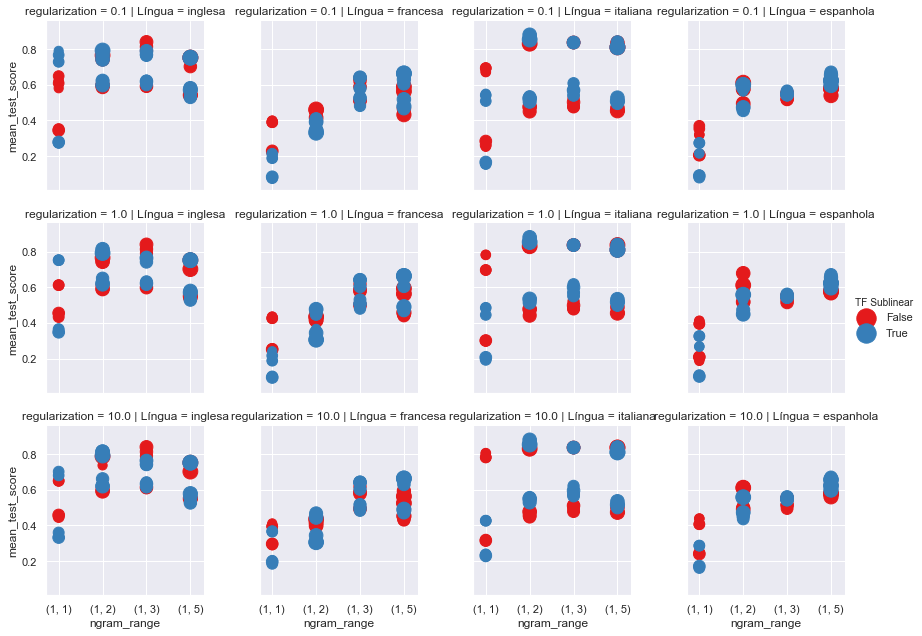

In [34]:
d = dfCV.copy()
d = d.rename(columns={'language':u'Língua', 'sublinear_tf':'TF Sublinear'})
d = d [ d.norm.isna() == False]
d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.problem = d.apply(lambda x: x[u'Língua'] +" "+ str(x[u'problem']), axis=1)
#d.ngram_range = d.apply(lambda x: str(x[u'ngram_range'][0]) +" "+ str(x[u'ngram_range'][1]), axis=1)

d.std_test_score =d.std_test_score / d.std_test_score.quantile(0.95) *500;
d.std_test_score +=1;
d.std_test_score = d.std_test_score.astype(np.int64)
g = sns.FacetGrid(d, col='Língua', hue='TF Sublinear',  row="regularization", height=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score",s=d.std_test_score.values).add_legend();
#sns.pairplot(d, hue="TF Sublinear", vars=["autorNumber", "mean_test_score"])


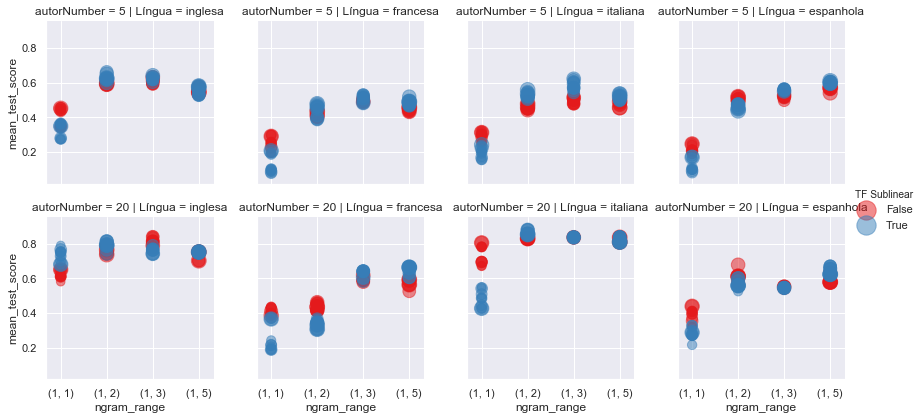

In [35]:
g = sns.FacetGrid(d, row='autorNumber', hue='TF Sublinear',  col=u"Língua", height=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

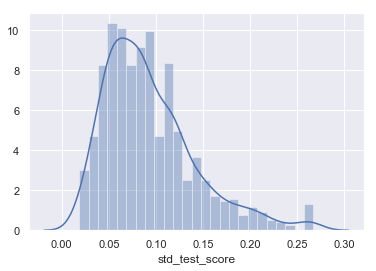

In [36]:
sns.distplot(dfCV.std_test_score, bins=25);

In [37]:
import statsmodels.api as sm

In [38]:
d = dfCV[['mean_test_score','problem', 'language','sublinear_tf','norm','ngram_range']].copy();
d.sublinear_tf=d.sublinear_tf.apply(lambda x: 1 if x else 0)
d.norm=d.norm.apply(lambda x: 1 if x=='l1' else 0)

d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.norm.fillna(value='None', inplace=True);

_, d['ngram_max'] = zip(*d.ngram_range.str.replace(r'[^\d,]','').str.split(',').values.tolist())
#d.ngram_min = d.ngram_min.astype(np.uint8);
d.ngram_max = d.ngram_max.astype(np.uint8);
d.drop(columns=['ngram_range','problem'], inplace=True)
#d['intercept'] = 1;

d=pd.get_dummies(d, columns=['language'])

In [39]:
d.describe()

,mean_test_score,sublinear_tf,norm,autorNumber,ngram_max,language_espanhola,language_francesa,language_inglesa,language_italiana
count,768.0000,768.0000,768.0000,768.0000,768.0000,768.0000,768.0000,768.0000,768.0000
mean,0.5448,0.5000,0.5000,12.5000,2.7500,0.2500,0.2500,0.2500,0.2500
std,0.1823,0.5003,0.5003,7.5049,1.4800,0.4333,0.4333,0.4333,0.4333
min,0.0768,0.0000,0.0000,5.0000,1.0000,0.0000,0.0000,0.0000,0.0000
25%,0.4474,0.0000,0.0000,5.0000,1.7500,0.0000,0.0000,0.0000,0.0000
50%,0.5520,0.5000,0.5000,12.5000,2.5000,0.0000,0.0000,0.0000,0.0000
75%,0.6417,1.0000,1.0000,20.0000,3.5000,0.2500,0.2500,0.2500,0.2500
max,0.8800,1.0000,1.0000,20.0000,5.0000,1.0000,1.0000,1.0000,1.0000


In [40]:
mod = sm.OLS( d.iloc[:,0], d.iloc[:,1:])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mean_test_score   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     196.5
Date:                Tue, 05 Feb 2019   Prob (F-statistic):          9.56e-166
Time:                        16:35:00   Log-Likelihood:                 614.59
No. Observations:                 768   AIC:                            -1213.
Df Residuals:                     760   BIC:                            -1176.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
sublinear_tf          -0.0158      0.008     -2.000      0.046      -0.031      -0.000
norm                   0.0016      0.008      0.201      0.841      -0.014       0.017
autorNumber            0.0119      0.001     22.680      0.000       0.011       0.013
ngram_max              0.0531      0.003     19.915      0.000       0.048       0.058
language_espanhola     0.1956      0.014     14.179      0.000       0.168       0.223
language_francesa      0.1531      0.014     11.098      0.000       0.126       0.180
language_inglesa       0.3546      0.014     25.710      0.000       0.328       0.382
language_italiana      0.3242      0.014     23.507      0.000       0.297       0.351
==============================================================================
Omnibus:                       92.274   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.804
Skew:                          -0.226   Prob(JB):                     2.05e-07
Kurtosis:                       2.129   Cond. No.                         91.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

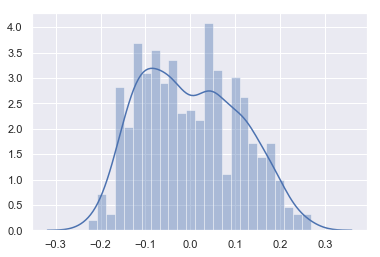

In [41]:
sns.distplot(res.predict()-d.iloc[:,0].values, bins=25)

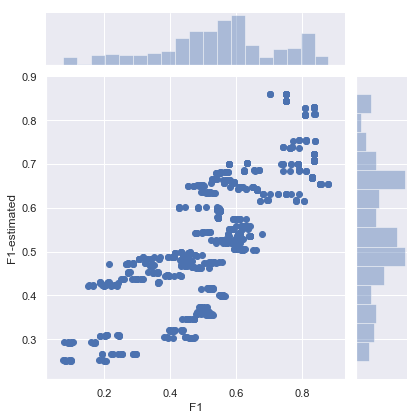

In [42]:
sns.jointplot(x='F1',y='F1-estimated',data=pd.DataFrame({'F1':d.iloc[:,0].values, 'F1-estimated':res.predict()}));

#  tests

In [43]:
problem = problems[0]
print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ');



Problem: problem00001,  language: en,  

In [46]:
def d(estimator, n_features=5):
    from IPython.display import Markdown, display, HTML
    names = np.array(estimator.named_steps['vect'].get_feature_names());
    classes_ = estimator.named_steps['clf'].classes_;
    weights = estimator.named_steps['clf'].coef_;
    
    def tag(tag, content, attrib=''):
        if attrib != '':
            attrib = ' style="' + attrib+'"'; 
        return ''.join(['<',tag,attrib,' >',content,'</',tag,'>']);
    
    def color(baseColor, intensity):
        r,g,b = baseColor[0:2],baseColor[2:4],baseColor[4:6]
        r,g,b = int(r, 16), int(g, 16), int(b, 16)
        
        f= (1-np.abs(intensity))/2;
        r = r + int((255-r)*f)
        g = g + int((255-g)*f)
        b = b + int((255-b)*f)
        rgb = '#%02x%x%x' % (r, g, b);
        #print(baseColor,rgb,r,g,b,intensity,f)
        return rgb
    
    
    spanStyle ='border-radius: 5px;margin:4px;padding:3px; color:#FFF !important;';
    
    lines = '<table>'+tag('thead',tag('th','Classes')+tag('th','positive')+tag('th','negative'))
    lines += '<tbody>'
    for i,c in enumerate(weights):
        c = np.round(c / np.abs(c).max(),2);
        positive = names[np.argsort(-c)][:n_features];
        positiveV = c[np.argsort(-c)][:n_features]
        negative = names[np.argsort(c)][:n_features];
        negativeV = c[np.argsort(c)][:n_features]
        
        lines += tag('tr',
                     tag('td', re.sub('\D0*','',classes_[i]))
                     + tag('td',''.join([tag('span',d.upper()+' '+str(v),spanStyle+'background:'+color('51A3DD',v)) for d,v in zip(positive,positiveV)]))
                     + tag('td',''.join([tag('span',d.upper()+' '+str(v),spanStyle+'background:'+color('DD5555',v)) for d,v in zip(negative,negativeV)]))
                    )
    lines+= '</tbody></table>'
        
    display(HTML(lines))
    #print(lines)
        
d(estimators[0])

1,-LRB- 1.0 DT 0.55 '' 0.47 UH 0.38 VBD 0.34,"CD -0.58 NNPS -0.47'' `` -0.28, JJ -0.26, EX -0.24"
2,PRP 1.0 DT 0.73$ 0.49'' CD 0.32 CC 0.32,JJ -0.92 VBZ -0.45 NNP -0.42'' PRP$ -0.38 NN -0.34
3,JJ 0.85 VBP 0.55 NNPS 0.38 '' 0.35 VBG 0.32,CC -1.0 -0.84 IN -0.34 CD -0.3$ CD -0.28
4,"NN 1.0'' '' 0.66'' , 0.65 '' 0.56'' JJ 0.5",NNP -0.89'' NNS -0.59 CD -0.56 IN -0.51'' MD -0.48
5,NNP 1.0 EX 0.8 CC 0.6 MD 0.6'' VBN 0.47,$ CD -0.62 -LRB- -0.59'' : -0.57 IN -0.48 DT -0.35
6,NNPS 0.76 NN 0.56 NNS 0.54 PRP$ 0.53 UH 0.49,DT -1.0 '' -0.84 VB -0.48 `` -0.41'' -RRB- -0.4
7,'' 0.69 VB 0.68'' MD 0.63'' JJR 0.58 WRB 0.55,"'' -1.0'' . -0.74 NN -0.63 CD -0.53, '' -0.46"
8,CD 0.81'' VBZ 0.59 JJ 0.53'' RB 0.47'' NN 0.45,MD -1.0 NNPS -0.98 WRB -0.95 '' -0.73 -0.65
9,1.0'' 0.55'' NN 0.53 WP 0.49'' VBN 0.49,-LRB- -0.99 EX -0.53'' '' -0.5 VBN -0.44 PRP -0.41
10,NNS 1.0 VBN 0.65 CD 0.58 VBD 0.52 -LRB- 0.48,PRP$ -0.71 NN -0.64 VBP -0.59 EX -0.57'' UH -0.48
11,NNS 1.0 0.87 NN 0.72 CC 0.59 PRP$ 0.56,EX -0.95 UH -0.6 WP -0.52'' : -0.5'' MD -0.5


In [ ]:
%%HTML
<table><tbody><tr><th>POS</th><th>Description</th><th>Examples</th></tr><tr >
<td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text u-text-small">adjective</td><td class="c-table__cell u-text u-text-small"><em>big, old, green, incomprehensible, first</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ADP</code></td><td class="c-table__cell u-text u-text-small">adposition</td><td class="c-table__cell u-text u-text-small"><em>in, to, during</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text u-text-small">adverb</td><td class="c-table__cell u-text u-text-small"><em>very, tomorrow, down, where, there</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>AUX</code></td><td class="c-table__cell u-text u-text-small">auxiliary</td><td class="c-table__cell u-text u-text-small"><em>is, has (done), will (do), should (do)</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CONJ</code></td><td class="c-table__cell u-text u-text-small">conjunction</td><td class="c-table__cell u-text u-text-small"><em>and, or, but</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CCONJ</code></td><td class="c-table__cell u-text u-text-small">coordinating conjunction</td><td class="c-table__cell u-text u-text-small"><em>and, or, but</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text u-text-small">determiner</td><td class="c-table__cell u-text u-text-small"><em>a, an, the</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>INTJ</code></td><td class="c-table__cell u-text u-text-small">interjection</td><td class="c-table__cell u-text u-text-small"><em>psst, ouch, bravo, hello</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text u-text-small">noun</td><td class="c-table__cell u-text u-text-small"><em>girl, cat, tree, air, beauty</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NUM</code></td><td class="c-table__cell u-text u-text-small">numeral</td><td class="c-table__cell u-text u-text-small"><em>1, 2017, one, seventy-seven, IV, MMXIV</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text u-text-small">particle</td><td class="c-table__cell u-text u-text-small"><em>'s, not, </em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text u-text-small">pronoun</td><td class="c-table__cell u-text u-text-small"><em>I, you, he, she, myself, themselves, somebody</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PROPN</code></td><td class="c-table__cell u-text u-text-small">proper noun</td><td class="c-table__cell u-text u-text-small"><em>Mary, John, London, NATO, HBO</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text u-text-small">punctuation</td><td class="c-table__cell u-text u-text-small"><em>., (, ), ?</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SCONJ</code></td><td class="c-table__cell u-text u-text-small">subordinating conjunction</td><td class="c-table__cell u-text u-text-small"><em>if, while, that</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text u-text-small">symbol</td><td class="c-table__cell u-text u-text-small"><em>$, %, §, ©, +, −, ×, ÷, =, :), 😝</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text u-text-small">verb</td><td class="c-table__cell u-text u-text-small"><em>run, runs, running, eat, ate, eating</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text u-text-small">other</td><td class="c-table__cell u-text u-text-small"><em>sfpksdpsxmsa</em></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SPACE</code></td><td class="c-table__cell u-text u-text-small">space</td></tr></tbody></table>

In [ ]:
%%HTML
<h1>English</h1>

<table class="c-table o-block"><tbody><tr class="c-table__row c-table__row--head"><th class="c-table__head-cell u-text-label">Tag</th><th class="c-table__head-cell u-text-label">POS</th><th class="c-table__head-cell u-text-label">Morphology</th><th class="c-table__head-cell u-text-label">Description</th></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>-LRB-</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=brck</code> <code>PunctSide=ini</code></td><td class="c-table__cell u-text u-text-small">left round bracket</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>-RRB-</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=brck</code> <code>PunctSide=fin</code></td><td class="c-table__cell u-text u-text-small">right round bracket</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>,</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=comm</code></td><td class="c-table__cell u-text u-text-small">punctuation mark, comma</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>:</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">punctuation mark, colon or ellipsis</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>.</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=peri</code></td><td class="c-table__cell u-text u-text-small">punctuation mark, sentence closer</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>''</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=quot</code> <code>PunctSide=fin</code></td><td class="c-table__cell u-text u-text-small">closing quotation mark</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>""</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=quot</code> <code>PunctSide=fin</code></td><td class="c-table__cell u-text u-text-small">closing quotation mark</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>#</code></td><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text"> <code>SymType=numbersign</code></td><td class="c-table__cell u-text u-text-small">symbol, number sign</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>``</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=quot</code> <code>PunctSide=ini</code></td><td class="c-table__cell u-text u-text-small">opening quotation mark</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>$</code></td><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text"> <code>SymType=currency</code></td><td class="c-table__cell u-text u-text-small">symbol, currency</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ADD</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">email</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>AFX</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Hyph=yes</code></td><td class="c-table__cell u-text u-text-small">affix</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>BES</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">auxiliary "be"</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CC</code></td><td class="c-table__cell u-text"><code>CONJ</code></td><td class="c-table__cell u-text"> <code>ConjType=coor</code></td><td class="c-table__cell u-text u-text-small">conjunction, coordinating</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CD</code></td><td class="c-table__cell u-text"><code>NUM</code></td><td class="c-table__cell u-text"> <code>NumType=card</code></td><td class="c-table__cell u-text u-text-small">cardinal number</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>DT</code></td><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text"> <code>determiner</code></td><td class="c-table__cell u-text u-text-small"></td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>EX</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>AdvType=ex</code></td><td class="c-table__cell u-text u-text-small">existential there</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>FW</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"> <code>Foreign=yes</code></td><td class="c-table__cell u-text u-text-small">foreign word</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>GW</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">additional word in multi-word expression</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>HVS</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">forms of "have"</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>HYPH</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=dash</code></td><td class="c-table__cell u-text u-text-small">punctuation mark, hyphen</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>IN</code></td><td class="c-table__cell u-text"><code>ADP</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">conjunction, subordinating or preposition</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>JJ</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Degree=pos</code></td><td class="c-table__cell u-text u-text-small">adjective</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>JJR</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Degree=comp</code></td><td class="c-table__cell u-text u-text-small">adjective, comparative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>JJS</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Degree=sup</code></td><td class="c-table__cell u-text u-text-small">adjective, superlative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>LS</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>NumType=ord</code></td><td class="c-table__cell u-text u-text-small">list item marker</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>MD</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbType=mod</code></td><td class="c-table__cell u-text u-text-small">verb, modal auxiliary</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NFP</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">superfluous punctuation</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NIL</code></td><td class="c-table__cell u-text"><code></code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">missing tag</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NN</code></td><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text"> <code>Number=sing</code></td><td class="c-table__cell u-text u-text-small">noun, singular or mass</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NNP</code></td><td class="c-table__cell u-text"><code>PROPN</code></td><td class="c-table__cell u-text"> <code>NounType=prop</code> <code>Number=sign</code></td><td class="c-table__cell u-text u-text-small">noun, proper singular</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NNPS</code></td><td class="c-table__cell u-text"><code>PROPN</code></td><td class="c-table__cell u-text"> <code>NounType=prop</code> <code>Number=plur</code></td><td class="c-table__cell u-text u-text-small">noun, proper plural</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NNS</code></td><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text"> <code>Number=plur</code></td><td class="c-table__cell u-text u-text-small">noun, plural</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PDT</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>AdjType=pdt</code> <code>PronType=prn</code></td><td class="c-table__cell u-text u-text-small">predeterminer</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>POS</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"> <code>Poss=yes</code></td><td class="c-table__cell u-text u-text-small">possessive ending</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PRP</code></td><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text"> <code>PronType=prs</code></td><td class="c-table__cell u-text u-text-small">pronoun, personal</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PRP$</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>PronType=prs</code> <code>Poss=yes</code></td><td class="c-table__cell u-text u-text-small">pronoun, possessive</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>RB</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>Degree=pos</code></td><td class="c-table__cell u-text u-text-small">adverb</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>RBR</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>Degree=comp</code></td><td class="c-table__cell u-text u-text-small">adverb, comparative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>RBS</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>Degree=sup</code></td><td class="c-table__cell u-text u-text-small">adverb, superlative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>RP</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">adverb, particle</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>_SP</code></td><td class="c-table__cell u-text"><code>SPACE</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">space</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text"><code>SYM</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">symbol</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>TO</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"> <code>PartType=inf</code> <code>VerbForm=inf</code></td><td class="c-table__cell u-text u-text-small">infinitival to</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>UH</code></td><td class="c-table__cell u-text"><code>INTJ</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">interjection</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VB</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=inf</code></td><td class="c-table__cell u-text u-text-small">verb, base form</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBD</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=fin</code> <code>Tense=past</code></td><td class="c-table__cell u-text u-text-small">verb, past tense</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBG</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=part</code> <code>Tense=pres</code> <code>Aspect=prog</code></td><td class="c-table__cell u-text u-text-small">verb, gerund or present participle</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBN</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=part</code> <code>Tense=past</code> <code>Aspect=perf</code></td><td class="c-table__cell u-text u-text-small">verb, past participle</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBP</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=fin</code> <code>Tense=pres</code></td><td class="c-table__cell u-text u-text-small">verb, non-3rd person singular present</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VBZ</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=fin</code> <code>Tense=pres</code> <code>Number=sing</code> <code>Person=3</code></td><td class="c-table__cell u-text u-text-small">verb, 3rd person singular present</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>WDT</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>PronType=int</code> <code>rel</code></td><td class="c-table__cell u-text u-text-small">wh-determiner</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>WP</code></td><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text"> <code>PronType=int</code> <code>rel</code></td><td class="c-table__cell u-text u-text-small">wh-pronoun, personal</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>WP$</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Poss=yes PronType=int</code> <code>rel</code></td><td class="c-table__cell u-text u-text-small">wh-pronoun, possessive</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>WRB</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>PronType=int</code> <code>rel</code></td><td class="c-table__cell u-text u-text-small">wh-adverb</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>XX</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">unknown</td></tr></tbody></table>

In [ ]:
%%HTML
<h1>German</h1>
<p> The German part-of-speech tagger uses the <a href="http://www.ims.uni-stuttgart.de/forschung/ressourcen/korpora/TIGERCorpus/annotation/index.html" target="_blank" rel="noopener nofollow">TIGER Treebank</a> annotation scheme. We also map the tags to the simpler Google
Universal POS tag set.</p>

<table class="c-table o-block"><tbody><tr class="c-table__row c-table__row--head"><th class="c-table__head-cell u-text-label">Tag</th><th class="c-table__head-cell u-text-label">POS</th><th class="c-table__head-cell u-text-label">Morphology</th><th class="c-table__head-cell u-text-label">Description</th></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>$(</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=brck</code></td><td class="c-table__cell u-text u-text-small">other sentence-internal punctuation mark</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>$,</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=comm</code></td><td class="c-table__cell u-text u-text-small">comma</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>$.</code></td><td class="c-table__cell u-text"><code>PUNCT</code></td><td class="c-table__cell u-text"> <code>PunctType=peri</code></td><td class="c-table__cell u-text u-text-small">sentence-final punctuation mark</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ADJA</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">adjective, attributive</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ADJD</code></td><td class="c-table__cell u-text"><code>ADJ</code></td><td class="c-table__cell u-text"> <code>Variant=short</code></td><td class="c-table__cell u-text u-text-small">adjective, adverbial or predicative</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">adverb</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>APPO</code></td><td class="c-table__cell u-text"><code>ADP</code></td><td class="c-table__cell u-text"> <code>AdpType=post</code></td><td class="c-table__cell u-text u-text-small">postposition</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>APPR</code></td><td class="c-table__cell u-text"><code>ADP</code></td><td class="c-table__cell u-text"> <code>AdpType=prep</code></td><td class="c-table__cell u-text u-text-small">preposition; circumposition left</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>APPRART</code></td><td class="c-table__cell u-text"><code>ADP</code></td><td class="c-table__cell u-text"> <code>AdpType=prep</code> <code>PronType=art</code></td><td class="c-table__cell u-text u-text-small">preposition with article</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>APZR</code></td><td class="c-table__cell u-text"><code>ADP</code></td><td class="c-table__cell u-text"> <code>AdpType=circ</code></td><td class="c-table__cell u-text u-text-small">circumposition right</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ART</code></td><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text"> <code>PronType=art</code></td><td class="c-table__cell u-text u-text-small">definite or indefinite article</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>CARD</code></td><td class="c-table__cell u-text"><code>NUM</code></td><td class="c-table__cell u-text"> <code>NumType=card</code></td><td class="c-table__cell u-text u-text-small">cardinal number</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>FM</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"> <code>Foreign=yes</code></td><td class="c-table__cell u-text u-text-small">foreign language material</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>ITJ</code></td><td class="c-table__cell u-text"><code>INTJ</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">interjection</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>KOKOM</code></td><td class="c-table__cell u-text"><code>CONJ</code></td><td class="c-table__cell u-text"> <code>ConjType=comp</code></td><td class="c-table__cell u-text u-text-small">comparative conjunction</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>KON</code></td><td class="c-table__cell u-text"><code>CONJ</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">coordinate conjunction</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>KOUI</code></td><td class="c-table__cell u-text"><code>SCONJ</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">subordinate conjunction with "zu" and infinitive</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>KOUS</code></td><td class="c-table__cell u-text"><code>SCONJ</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">subordinate conjunction with sentence</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NE</code></td><td class="c-table__cell u-text"><code>PROPN</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">proper noun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NNE</code></td><td class="c-table__cell u-text"><code>PROPN</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">proper noun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>NN</code></td><td class="c-table__cell u-text"><code>NOUN</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">noun, singular or mass</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PAV</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>PronType=dem</code></td><td class="c-table__cell u-text u-text-small">pronominal adverb</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PROAV</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>PronType=dem</code></td><td class="c-table__cell u-text u-text-small">pronominal adverb</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PDAT</code></td><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text"> <code>PronType=dem</code></td><td class="c-table__cell u-text u-text-small">attributive demonstrative pronoun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PDS</code></td><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text"> <code>PronType=dem</code></td><td class="c-table__cell u-text u-text-small">substituting demonstrative pronoun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PIAT</code></td><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text"> <code>PronType=ind</code> <code>neg</code> <code>tot</code></td><td class="c-table__cell u-text u-text-small">attributive indefinite pronoun without determiner</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PIDAT</code></td><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text"> <code>AdjType=pdt PronType=ind</code> <code>neg</code> <code>tot</code></td><td class="c-table__cell u-text u-text-small">attributive indefinite pronoun with determiner</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PIS</code></td><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text"> <code>PronType=ind</code> <code>neg</code> <code>tot</code></td><td class="c-table__cell u-text u-text-small">substituting indefinite pronoun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PPER</code></td><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text"> <code>PronType=prs</code></td><td class="c-table__cell u-text u-text-small">non-reflexive personal pronoun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PPOSAT</code></td><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text"> <code>Poss=yes</code> <code>PronType=prs</code></td><td class="c-table__cell u-text u-text-small">attributive possessive pronoun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PPOSS</code></td><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text"> <code>PronType=rel</code></td><td class="c-table__cell u-text u-text-small">substituting possessive pronoun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PRELAT</code></td><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text"> <code>PronType=rel</code></td><td class="c-table__cell u-text u-text-small">attributive relative pronoun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PRELS</code></td><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text"> <code>PronType=rel</code></td><td class="c-table__cell u-text u-text-small">substituting relative pronoun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PRF</code></td><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text"> <code>PronType=prs</code> <code>Reflex=yes</code></td><td class="c-table__cell u-text u-text-small">reflexive personal pronoun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PTKA</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">particle with adjective or adverb</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PTKANT</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"> <code>PartType=res</code></td><td class="c-table__cell u-text u-text-small">answer particle</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PTKNEG</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"> <code>Negative=yes</code></td><td class="c-table__cell u-text u-text-small">negative particle</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PTKVZ</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"> <code>PartType=vbp</code></td><td class="c-table__cell u-text u-text-small">separable verbal particle</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PTKZU</code></td><td class="c-table__cell u-text"><code>PART</code></td><td class="c-table__cell u-text"> <code>PartType=inf</code></td><td class="c-table__cell u-text u-text-small">"zu" before infinitive</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PWAT</code></td><td class="c-table__cell u-text"><code>DET</code></td><td class="c-table__cell u-text"> <code>PronType=int</code></td><td class="c-table__cell u-text u-text-small">attributive interrogative pronoun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PWAV</code></td><td class="c-table__cell u-text"><code>ADV</code></td><td class="c-table__cell u-text"> <code>PronType=int</code></td><td class="c-table__cell u-text u-text-small">adverbial interrogative or relative pronoun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>PWS</code></td><td class="c-table__cell u-text"><code>PRON</code></td><td class="c-table__cell u-text"> <code>PronType=int</code></td><td class="c-table__cell u-text u-text-small">substituting interrogative pronoun</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>TRUNC</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"> <code>Hyph=yes</code></td><td class="c-table__cell u-text u-text-small">word remnant</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VAFIN</code></td><td class="c-table__cell u-text"><code>AUX</code></td><td class="c-table__cell u-text"> <code>Mood=ind</code> <code>VerbForm=fin</code></td><td class="c-table__cell u-text u-text-small">finite verb, auxiliary</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VAIMP</code></td><td class="c-table__cell u-text"><code>AUX</code></td><td class="c-table__cell u-text"> <code>Mood=imp</code> <code>VerbForm=fin</code></td><td class="c-table__cell u-text u-text-small">imperative, auxiliary</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VAINF</code></td><td class="c-table__cell u-text"><code>AUX</code></td><td class="c-table__cell u-text"> <code>VerbForm=inf</code></td><td class="c-table__cell u-text u-text-small">infinitive, auxiliary</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VAPP</code></td><td class="c-table__cell u-text"><code>AUX</code></td><td class="c-table__cell u-text"> <code>Aspect=perf</code> <code>VerbForm=fin</code></td><td class="c-table__cell u-text u-text-small">perfect participle, auxiliary</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VMFIN</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>Mood=ind</code> <code>VerbForm=fin</code> <code>VerbType=mod</code></td><td class="c-table__cell u-text u-text-small">finite verb, modal</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VMINF</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=fin</code> <code>VerbType=mod</code></td><td class="c-table__cell u-text u-text-small">infinitive, modal</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VMPP</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>Aspect=perf</code> <code>VerbForm=part</code> <code>VerbType=mod</code></td><td class="c-table__cell u-text u-text-small">perfect participle, modal</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VVFIN</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>Mood=ind</code> <code>VerbForm=fin</code></td><td class="c-table__cell u-text u-text-small">finite verb, full</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VVIMP</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>Mood=imp</code> <code>VerbForm=fin</code></td><td class="c-table__cell u-text u-text-small">imperative, full</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VVINF</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=inf</code></td><td class="c-table__cell u-text u-text-small">infinitive, full</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VVIZU</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>VerbForm=inf</code></td><td class="c-table__cell u-text u-text-small">infinitive with "zu", full</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>VVPP</code></td><td class="c-table__cell u-text"><code>VERB</code></td><td class="c-table__cell u-text"> <code>Aspect=perf</code> <code>VerbForm=part</code></td><td class="c-table__cell u-text u-text-small">perfect participle, full</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>XY</code></td><td class="c-table__cell u-text"><code>X</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">non-word containing non-letter</td></tr><tr class="c-table__row"><td class="c-table__cell u-text"><code>SP</code></td><td class="c-table__cell u-text"><code>SPACE</code></td><td class="c-table__cell u-text"></td><td class="c-table__cell u-text u-text-small">space</td></tr></tbody></table>